# Adversarial example for convolutional network

In this notebook, we shall be looking at a case of adversarial examples. Adversarial examples are images which have been perturbed in a manner which makes the network misclassify the image.

At the heart of this application is the calculation of the gradient of a loss function with respect to the image itself (instead of respect to the weights).

Keras programming framework gives us the possibility to use a famous pretrained network : VGG16. There are useful predefined function which allow us to load the weights, view the architecture etc.

https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py

https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
# Disable warnings
tf.logging.set_verbosity(tf.logging.ERROR)

### Load necessary packages

In [2]:
import numpy as np
from keras.preprocessing.image import load_img,img_to_array
from keras.applications import vgg16
#from keras.applications import inception_v3
from keras import backend as K
from keras.layers import Input
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


### Loading the VGG16 model

In [3]:
# This removes all operations linked to training the model
K.set_learning_phase(0)
# Load the model
model=vgg16.VGG16(weights='imagenet',include_top=True)
# Creating layer dictionary for easy layer reference
layer_dict = dict([ (layer.name,layer) for layer in model.layers])
# Creating backend Tensor
img_backend = model.input
# displaying model architecture
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Preprocessing image functions

In [0]:
def format_image_classif(img_file,img_width=224,img_height=224):
    """
    This function reads and formats an image so that it can be fed to the VGG16 network.
    In this case, we wish to force the image size to a certain shape, since we want to use the image for
    classification
    
    Parameters
    ----------
    img_file : image file name
    img_width : the target image width
    img_height : he target image height
    
    Returns
    -------
    img_out_vgg : the correctly formatted image for VGG16
    img : the image as read by the load_img function of keras.preprocessing.image
    """
    # read image. Force the image size to a certain shape (uses a resize of the pillow package)
    img = load_img(img_file,target_size=(img_height,img_width))
    # convert image to an array
    img_out = img_to_array(img)
    # preprocess the image to put in the correct format for use with the VGG16 network trained on imagenet
    img_out_vgg = vgg16.preprocess_input(img_out)
    # add a dimension at the beginning, coresponding to the batch dimension
    img_out_vgg = np.expand_dims(img_out_vgg, axis=0)
    return img_out_vgg, img

def unformat_image(img_in):
    """
    This function inverts the preprocessing applied to images for use in the VGG16 network
    
    Parameters
    ----------
    img_file : formatted image of shape (batch_size,m,n,3)
    
    Returns
    -------
    img_out : a m-by-n-by-3 array, representing an image that can be written to an image file
    """
    #get rid of batch dimension
    img_out=np.squeeze(img_in)
    #remove offsets added by the VGG16 preprocessing
    img_out[:, :, 0] += 103.939
    img_out[:, :, 1] += 116.779
    img_out[:, :, 2] += 123.68
    # invert the order of the colours : BGR -> RGB
    img_out = img_out[:, :, ::-1]
    #clamp image to the range [0,255] and cast to uint8
    img_out = np.clip(img_out, 0, 255).astype('uint8')
    return img_out

### Gradient maximisation approach

We will try to make the model misclassify a cat picture.

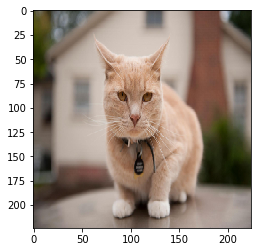

In [5]:
img_in,img_visu = format_image_classif('images/cat_small.png')

plt.imshow(img_visu)

In [6]:
img_in.shape

(1, 224, 224, 3)

We shall retrieve the last (prediction) layer of the VGG network.
We are going to try to force the image to recognise a 'reflex_camera'. This is number 759 of the imagenet classes (we could use any other we like in fact).

In [0]:
prediction_layer = layer_dict['predictions'].output

In [8]:
target_class = 759

# Initial prediction before gradient maximisation approach
y_predicted = model.predict(img_in)
# First prediction
initial_class = vgg16.decode_predictions(y_predicted, top=1)[0]
print(initial_class)

[('n02124075', 'Egyptian_cat', 0.6696212)]


We can take a look at the top 5 predicted classes with the prediction probabilities.

In [9]:
initial_top_classes = vgg16.decode_predictions(y_predicted, top=5)[0]
print(initial_top_classes)

[('n02124075', 'Egyptian_cat', 0.6696212), ('n02123045', 'tabby', 0.1223429), ('n02123159', 'tiger_cat', 0.09129722), ('n02127052', 'lynx', 0.03252159), ('n04141975', 'scale', 0.0050705103)]


Now, we will define the loss and gradient. To misclassify the image, the loss has to be defined to be the 'target_class' prediction of the last layer of the network. As we will try to maximise this loss, it will fool the network after some gradient iterations.

In [0]:
# define loss and gradients
loss = prediction_layer[:, target_class]
grads = K.gradients(loss, img_backend)[0]
# normalize the gradient
grads_normalised = grads/ (K.maximum(K.mean(K.abs(grads)), K.epsilon()))
# create function to retrieve loss and gradients of loss with respect to image
get_loss_and_grads_class = K.function([img_backend],[loss,grads_normalised])

We are now ready to perturb the image such that we misclassify it!

In [11]:
#reload image, to make sure we are not starting from previous point
img_in,_ = format_image_classif('images/cat_small.png')
img_initial = np.copy(img_in)
initial_class = vgg16.decode_predictions(model.predict(img_initial), top=1)[0]

step = 0.5  # Gradient ascent step size
n_iterations = 100
for i in range(0, n_iterations):
    loss_value,grads_value = get_loss_and_grads_class([img_in])
    img_in = img_in + grads_value * step
    if (i%5==0):
        y_predicted = model.predict(img_in)
        # Observe the evolution of the prediction probability
        print(vgg16.decode_predictions(y_predicted, top=1)[0])
print('End of optimisation')

[('n02124075', 'Egyptian_cat', 0.66840696)]
[('n02124075', 'Egyptian_cat', 0.6617605)]
[('n02124075', 'Egyptian_cat', 0.65379727)]
[('n02124075', 'Egyptian_cat', 0.64406085)]
[('n02124075', 'Egyptian_cat', 0.6316786)]
[('n02124075', 'Egyptian_cat', 0.61577106)]
[('n02124075', 'Egyptian_cat', 0.59275913)]
[('n02124075', 'Egyptian_cat', 0.5530831)]
[('n02124075', 'Egyptian_cat', 0.48783308)]
[('n02124075', 'Egyptian_cat', 0.34709814)]
[('n02124075', 'Egyptian_cat', 0.08351554)]
[('n04069434', 'reflex_camera', 0.9788574)]
[('n04069434', 'reflex_camera', 0.99991345)]
[('n04069434', 'reflex_camera', 0.99994946)]
[('n04069434', 'reflex_camera', 0.9999628)]
[('n04069434', 'reflex_camera', 0.99996996)]
[('n04069434', 'reflex_camera', 0.99997485)]
[('n04069434', 'reflex_camera', 0.99997795)]
[('n04069434', 'reflex_camera', 0.99998057)]
[('n04069434', 'reflex_camera', 0.9999826)]
End of optimisation


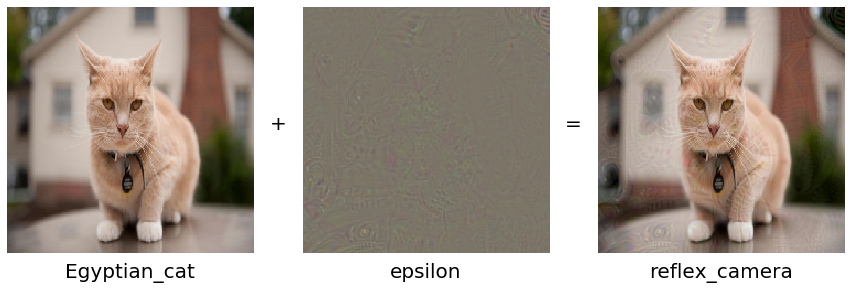

In [15]:
# Misclassified image
img_show = unformat_image(np.copy(img_in))

# Final prediction after perturbation
y_predicted = model.predict(img_in)
final_class = vgg16.decode_predictions(y_predicted, top=1)[0]

# Decoding the perturbation image
epsilon = img_in - img_initial
epsilon_show = unformat_image(np.copy(epsilon))

plt.figure(figsize=(15,8))

ax1 = plt.subplot(1, 3, 1)
# Initial class
ax1.imshow(img_visu)
ax1.text(0.5,-0.1, initial_class[0][1], size=20, ha='center', 
         transform=ax1.transAxes)
ax1.text(1.1, 0.5, '+', size=20, ha='center', 
         transform=ax1.transAxes)

ax2 = plt.subplot(1, 3, 2)
# Perturbation
ax2.imshow(epsilon_show)
ax2.text(0.5,-0.1, "epsilon", size=20, ha='center', 
         transform=ax2.transAxes)
ax2.text(1.1, 0.5, "=", size=20, ha='center', 
         transform=ax2.transAxes)

ax3 = plt.subplot(1, 3, 3)
# Final class
ax3.imshow(img_show)
ax3.text(0.5,-0.1, final_class[0][1], size=20, ha='center', 
         transform=ax3.transAxes)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

plt.show()

As we can see, the image is changed such that it is no longer recognized as a cat.

In [13]:
print(vgg16.decode_predictions(y_predicted, top=5)[0])

[('n04069434', 'reflex_camera', 0.9999838), ('n03657121', 'lens_cap', 5.036332e-06), ('n03976467', 'Polaroid_camera', 4.6234363e-06), ('n04404412', 'television', 1.1501785e-06), ('n02979186', 'cassette_player', 1.0974577e-06)]


Moreover, the top 5 classifications don't have nothing to do with cats anymore.